# Energy-Preserving Integration for a Double Pendulum with Torsional Springs

This notebook demonstrates **conjugate homogeneous projection**, a powerful technique for preserving energy in numerical integration of conservative dynamical systems.

## The Problem

We consider a double pendulum where both joints have torsional springs. The system has 4 state variables:
- `q1`, `q2`: angles of the two pendulums
- `p1`, `p2`: conjugate momenta

The Hamiltonian (total energy) is:
$$H(q_1, q_2, p_1, p_2) = \frac{p_1^2 + 2p_2^2 - 2\cos(q_1 - q_2)p_1p_2}{4 - 2\cos(q_1 - q_2)^2} + \frac{1}{2}q_1^2 + \frac{1}{2}q_2^2$$

The torsional springs (the $\frac{1}{2}q_i^2$ terms) make this system particularly challenging because the energy is not polynomial in the momenta alone.

## Why Standard Methods Fail

Standard numerical integrators like Runge-Kutta methods do not preserve energy exactly. Over long time periods, this energy drift can lead to qualitatively wrong behavior - orbits spiral in or out, periodic motion becomes unstable, etc.

**Goal**: Preserve energy *exactly* at every time step while maintaining good accuracy and efficiency.

In [37]:
# Import necessary libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.integrate._ivp.rk import RK45, DOP853
import time

# Add parent directory to path
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from homproj.dynamics import HamiltonianSystem
from homproj.linhomproj import LinearHomogeneousProjector
from homproj import HomogeneousProjector
from homproj.numeric import rk4
from dputils import run_experiment, plot_trajectories, plot_analysis_over_initial_conditions, create_pendulum_animation

## Step 1: Define the Hamiltonian System

First, we set up our Hamiltonian and generate the equations of motion using Hamilton's equations:
$$\dot{q}_i = \frac{\partial H}{\partial p_i}, \quad \dot{p}_i = -\frac{\partial H}{\partial q_i}$$

In [38]:
# Define symbolic variables
q1, q2, p1, p2 = sp.symbols('q1 q2 p1 p2', real=True)
variables = [q1, q2, p1, p2]

# Define the Hamiltonian (energy function)
H_sym = (p1**2 + 2*p2**2 - 2*sp.cos(q1 - q2)*p1*p2)/(4 - 2*sp.cos(q1 - q2)**2) + 1/2*q1**2 + 1/2*q2**2

# Create the dynamical system from the Hamiltonian
f_pendulum = HamiltonianSystem(H_sym, variables).f

# Create a numerical function for computing energy
H_fun = sp.lambdify(variables, H_sym, 'numpy')

def compute_energy(state):
    """Compute the Hamiltonian (energy) for a given state or trajectory"""
    if state.ndim == 1:
        return H_fun(*state)
    else:
        return np.array([H_fun(*row) for row in state])

def f(t, y):
    """Dynamics function for scipy integrators"""
    return f_pendulum(y)

print("Hamiltonian system created successfully!")
print(f"State dimension: {len(variables)}")

Hamiltonian system created successfully!
State dimension: 4


## Step 2: The Key Idea - Conjugate Homogeneity

The key insight is that while $H(q,p)$ is complicated, we can find a **change of coordinates** $\phi: (q,p) \to (y)$ such that in the new coordinates, the energy becomes a **homogeneous function**:

$$G(y) = G(\lambda y) \cdot \lambda^{-k}$$

for some degree $k$. For our system, we use:
- $k = 2$ (quadratic homogeneity)
- Generator: $\nu = [1, 1, 1, 1]$ (all coordinates scale together)

The transformation $\phi$ and its inverse $\phi^{-1}$ allow us to:
1. Transform to conjugate space: $y = \phi(x)$
2. Apply a simple scaling: $\tilde{y} = e^{\nu t} y$ (which preserves $G$ due to homogeneity!)
3. Transform back: $\tilde{x} = \phi^{-1}(\tilde{y})$

This gives us an **exact** energy-preserving map!

In [39]:
# Define the homogeneous function G in conjugate coordinates
def G(y):
    """The homogeneous energy function: G(y) is quadratic (degree k=2)"""
    y1, y2, y3, y4 = y
    return 0.5*y1**2 + 0.5*y2**2 + y3**2 + y4**2

# Define the coordinate transformation phi: x -> y
def phi(x):
    """Transform from physical coordinates (q1,q2,p1,p2) to conjugate coordinates"""
    x1, x2, x3, x4 = x
    c12 = np.cos(x1 - x2)
    D = np.sqrt(2.0 - c12*c12)
    
    y1 = x1  # q1 unchanged
    y2 = x2  # q2 unchanged
    y3 = 0.5*x3  # p1 scaled
    y4 = (2.0*x4 - c12*x3)/(2.0*D)  # p2 transformed nonlinearly
    return np.array([y1, y2, y3, y4])

# Define the inverse transformation phi^{-1}: y -> x
def phi_inv(y, x_prev=None):
    """Transform from conjugate coordinates back to physical coordinates"""
    y1, y2, y3, y4 = y
    
    x1 = y1  # q1 unchanged
    x2 = y2  # q2 unchanged
    x3 = 2.0*y3  # p1 inverse scaled
    
    c12 = np.cos(x1 - x2)
    D = np.sqrt(2.0 - c12*c12)
    x4 = 0.5*c12*x3 + D*y4  # p2 inverse transform
    return np.array([x1, x2, x3, x4])

print("Coordinate transformations defined!")

Coordinate transformations defined!


## Step 3: Verify the Conjugate Homogeneity Property

Let's verify that our transformation works correctly. We need to check three things:

1. **Conjugacy**: $G(\phi(x)) = H(x)$ (energy is preserved by the transformation)
2. **Homogeneity**: $G(e^t \cdot y) = e^{2t} \cdot G(y)$ (G is degree-2 homogeneous)
3. **Composition**: $H(\phi^{-1}(e^t \cdot \phi(x))) = e^{2t} \cdot H(x)$ (conjugate homogeneity)

In [40]:
# Test the properties with a random state
k = 2  # Homogeneity degree
t = 0.01  # Small time parameter
x = np.array([0.5, 1.0, 2.0, 1.0])  # Random state

# Compute exponential scaling
exp_nu = np.exp(np.array([1, 1, 1, 1]) * t)

# Test 1: Conjugacy
conjugacy_error = G(phi(x)) - H_fun(*x)
print(f"✓ Conjugacy test: G(φ(x)) - H(x) = {conjugacy_error:.2e}")
print(f"  (Should be ≈ 0)")

# Test 2: Homogeneity
homogeneity_error = G(exp_nu * phi(x)) - np.exp(k*t) * G(phi(x))
print(f"\n✓ Homogeneity test: G(e^t·y) - e^(kt)·G(y) = {homogeneity_error:.2e}")
print(f"  (Should be ≈ 0)")

# Test 3: Conjugate homogeneity
conj_hom_error = H_fun(*phi_inv(exp_nu * phi(x))) - np.exp(k*t) * H_fun(*x)
print(f"\n✓ Conjugate homogeneity: H(φ⁻¹(e^t·φ(x))) - e^(kt)·H(x) = {conj_hom_error:.2e}")
print(f"  (Should be ≈ 0)")

print("\n✅ All properties verified! The transformation is valid.")

✓ Conjugacy test: G(φ(x)) - H(x) = 0.00e+00
  (Should be ≈ 0)

✓ Homogeneity test: G(e^t·y) - e^(kt)·G(y) = -2.22e-16
  (Should be ≈ 0)

✓ Conjugate homogeneity: H(φ⁻¹(e^t·φ(x))) - e^(kt)·H(x) = -4.44e-16
  (Should be ≈ 0)

✅ All properties verified! The transformation is valid.


## Step 4: Simple Example - Short Time Integration

Let's start with a **small example** to see how the method works. We'll integrate for just 10 time units with a simple initial condition.

In [41]:
# Simple initial condition for the short example
y0_simple = np.array([np.pi, 0, 2.0, -0.5])

# Set up the projection methods
print("Setting up projection methods...")

# Method 1: Conjugate Homogeneous Projection (exact energy preservation)
conj_hom_proj = LinearHomogeneousProjector(
    invariant=H_fun,
    generator=np.array([1, 1, 1, 1]),
    degree=2,
    initial_state=y0_simple,
    phi=phi,
    phi_inv=phi_inv,
)

# Method 2: Pseudo-Newton Homogeneous Projection (iterative, approximate)
pseudo_hom_proj = HomogeneousProjector(
    invariants=H_fun,
    initial_state=y0_simple,
    integrator='rk2',
    max_iterations=1,
)

# Create projected integrators (base integrator + projection)
rk4_conj = lambda x, h, f: conj_hom_proj.project(rk4(x, h, f))
rk4_pseudo = lambda x, h, f: pseudo_hom_proj.project(rk4(x, h, f))

print("✓ Projection methods initialized")

Setting up projection methods...
✓ Projection methods initialized


In [42]:
# Run the simple example
print("Running simple example (T=10, dt=0.05)...")

solver_methods_simple = [
    ('RK4 (standard)', rk4),
    ('CH-RK4 (conjugate homogeneous)', rk4_conj),
    ('PNH-RK4 (pseudo-Newton)', rk4_pseudo),
    ('Reference (DOP853)', DOP853),
]

# Integrate
solutions_simple, timings_simple = run_experiment(
    solver_methods_simple, 
    y0_simple, 
    tmax=50,  # Short time
    tol=1e-12, 
    timestep=0.05,
    f=f
)

initial_energy_simple = compute_energy(y0_simple)
print(f"✓ Integration complete. Initial energy: {initial_energy_simple:.6f}")

Running simple example (T=10, dt=0.05)...
Running RK4 (standard)...
Running CH-RK4 (conjugate homogeneous)...
Running PNH-RK4 (pseudo-Newton)...
Running Reference (DOP853)...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


✓ Integration complete. Initial energy: 6.184802


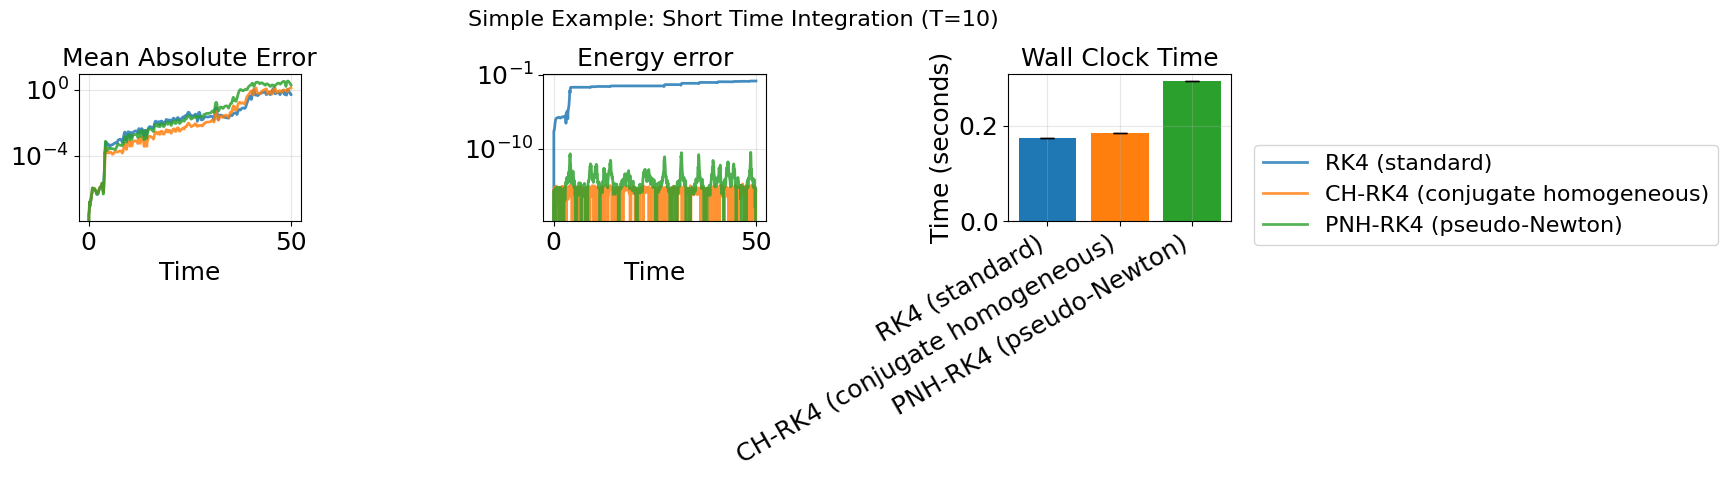

In [43]:
# Visualize the simple example results
fig_simple = plot_analysis_over_initial_conditions(
    solutions_list=[solutions_simple],
    compute_energy=compute_energy,
    initial_energies=[initial_energy_simple],
    timings=[timings_simple],
)
plt.suptitle('Simple Example: Short Time Integration (T=10)', fontsize=16, y=1.02)
plt.show()

### Observations from the Simple Example

From the plots above, we can see:

1. **Energy Error**: The conjugate homogeneous method (CH-RK4) preserves energy to **machine precision** (~10⁻¹⁴), while standard RK4 accumulates error over time.

2. **Trajectory Error**: Despite perfect energy conservation, CH-RK4 still has some trajectory error compared to the high-accuracy reference. This is because energy conservation is necessary but not sufficient for trajectory accuracy.

3. **Performance**: The projection adds minimal computational overhead compared to the base RK4 method.

## Step 5: Create an Animation of the Simple Example

Let's visualize how the pendulum actually moves! We'll create an animated GIF showing:
- The pendulum position
- The x-coordinate time series
- Energy error over time

Animation saved to double_pendulum_simple.gif


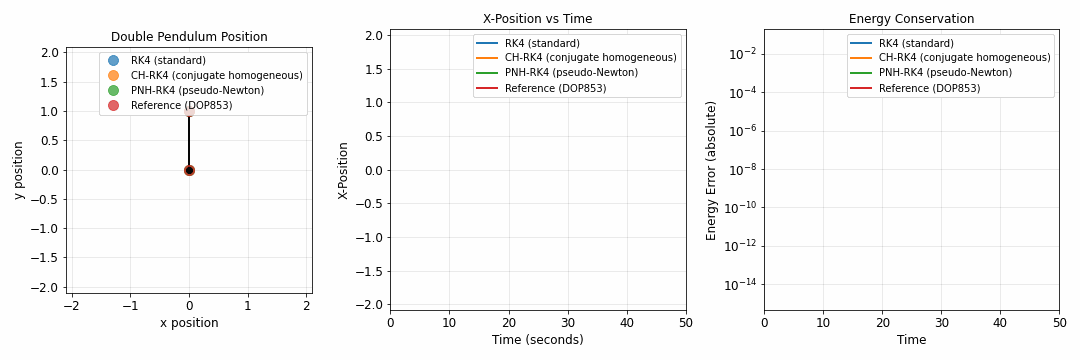

✓ Animation created and displayed!


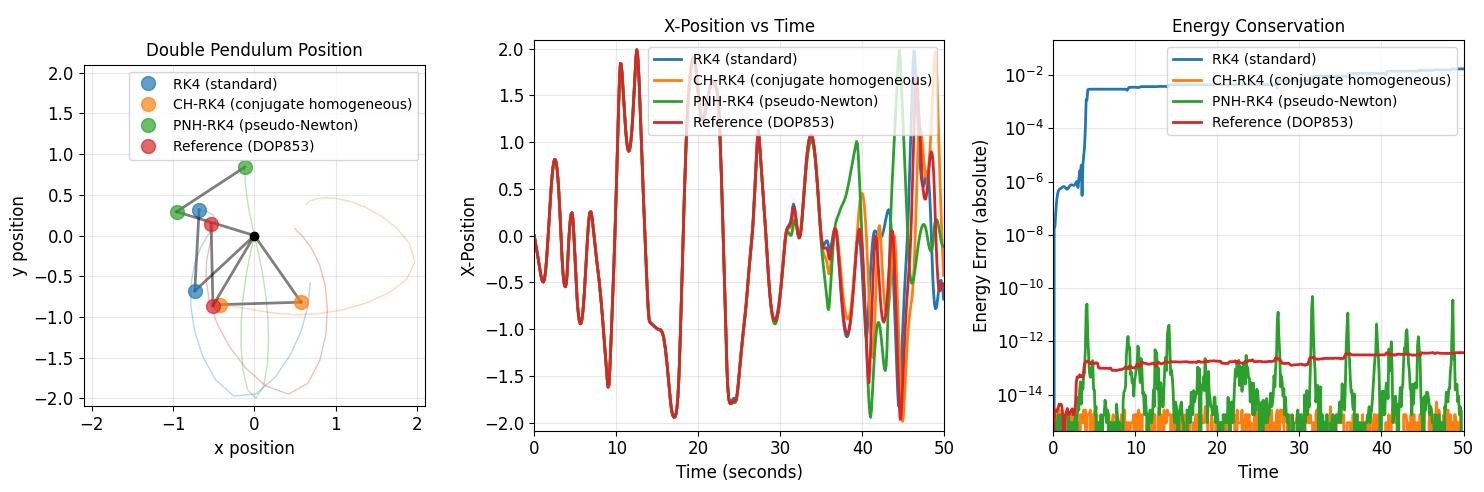

In [44]:
# Create animated GIF of the simple example
animation_simple = create_pendulum_animation(
    solutions=solutions_simple,
    compute_energy=compute_energy,
    initial_energy=initial_energy_simple,
    filename='double_pendulum_simple.gif',
    fps=20,
    time_step=0.1
)

# Try to display in notebook
from IPython.display import Image
try:
    display(Image(filename='double_pendulum_simple.gif'))
    print("✓ Animation created and displayed!")
except Exception as e:
    print(f"✓ Animation saved to 'double_pendulum_simple.gif'")
    print(f"  (Could not display in notebook: {e})")